# Imports

In [64]:
from pathlib import Path
import pandas as pd
from xml.etree import ElementTree as ET
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import re



DATA_ROOT = Path("KWS")

# Load the .tsv files and build a word table

In [65]:
# 1) Load transcription table: word_id -> transcription
trans_df = pd.read_csv(
    DATA_ROOT / "transcription.tsv",
    sep="\t",
    header=None,
    names=["word_id", "transcription"],
    dtype=str,
)

print("Transcriptions:")
print(trans_df.head())

# 2) Load train / validation document lists
train_docs = pd.read_csv(
    DATA_ROOT / "train.tsv",
    sep="\t",
    header=None,
    names=["doc_id"],
    dtype=str,
)

val_docs = pd.read_csv(
    DATA_ROOT / "validation.tsv",
    sep="\t",
    header=None,
    names=["doc_id"],
    dtype=str,
)

train_doc_set = set(train_docs["doc_id"])
val_doc_set = set(val_docs["doc_id"])

print("Number of train docs:", len(train_doc_set))
print("Number of val docs:", len(val_doc_set))

# 3) Split word_id into (doc, line, word)
def split_word_id(word_id: str):
    """
    Split an ID like '270-05-07' into (doc_id, line_id, word_idx).
     Args:
        word_id (str): Word ID in the format 'doc-line-word'.
     Returns:
        tuple: (doc_id, line_id, word_idx)
    """
    doc, line, word = word_id.split("-")
    return doc, line, word

words_df = trans_df.copy()
words_df[["doc_id", "line_id", "word_idx"]] = (
    words_df["word_id"]
    .apply(split_word_id)
    .apply(pd.Series)
)

# 4) Assign split based on document id
def get_split(doc_id: str) -> str:
    """
    Determine the data split for a given document ID.
     Args:
        doc_id (str): Document ID.
     Returns:
        str: "train", "val", or "unknown".
    """
    if doc_id in train_doc_set:
        return "train"
    elif doc_id in val_doc_set:
        return "val"
    else:
        return "unknown"

words_df["split"] = words_df["doc_id"].apply(get_split)

print("\nWords DataFrame:")
print(words_df.head())
print("\nSplit value counts:")
print(words_df["split"].value_counts())


Transcriptions:
     word_id                 transcription
0  270-01-01              s_2-s_7-s_0-s_pt
1  270-01-02            L-e-t-t-e-r-s-s_cm
2  270-01-03                   O-r-d-e-r-s
3  270-01-04                         a-n-d
4  270-01-05  I-n-s-t-r-u-c-t-i-o-n-s-s_pt
Number of train docs: 10
Number of val docs: 5

Words DataFrame:
     word_id                 transcription doc_id line_id word_idx  split
0  270-01-01              s_2-s_7-s_0-s_pt    270      01       01  train
1  270-01-02            L-e-t-t-e-r-s-s_cm    270      01       02  train
2  270-01-03                   O-r-d-e-r-s    270      01       03  train
3  270-01-04                         a-n-d    270      01       04  train
4  270-01-05  I-n-s-t-r-u-c-t-i-o-n-s-s_pt    270      01       05  train

Split value counts:
split
train    2433
val      1293
Name: count, dtype: int64


# Extract images of words

## Path

In [66]:
IMAGES_DIR = DATA_ROOT / "images"
LOCATIONS_DIR = DATA_ROOT / "locations"

## Find the page image and SVG for a document

In [67]:
def find_page_image(doc_id: str) -> Image.Image:
    """
    Return the PIL image for a given document id.

    Args:
        doc_id (str): Document identifier, e.g. "270".

    Returns:
        Image.Image: Grayscale page image.
    """
    exts = ("png", "jpg", "jpeg", "tif", "tiff", "bmp")
    for ext in exts:
        candidates = list(IMAGES_DIR.glob(f"*{doc_id}*.{ext}"))
        if candidates:
            img_path = candidates[0]
            return Image.open(img_path).convert("L")  # grayscale
    raise FileNotFoundError(f"No page image found for doc_id={doc_id!r}")


def find_svg_for_doc(doc_id: str) -> Path:
    """
    Return the SVG file path for a given document id.

    Args:
        doc_id (str): Document identifier, e.g. "270".

    Returns:
        Path: Path to the SVG file.
    """
    candidates = list(LOCATIONS_DIR.glob(f"*{doc_id}*.svg"))
    if not candidates:
        raise FileNotFoundError(f"No SVG found for doc_id={doc_id!r}")
    if len(candidates) > 1:
        print(f"Warning: multiple SVGs for doc {doc_id}, using {candidates[0].name}")
    return candidates[0]


## Retrieve the polygon of a word in SVG

In [68]:
def get_word_polygon(doc_id: str, word_id: str):
    """
    Parse the SVG for a given document and extract polygon points for a word.

    Each word is a <path> element with:
        id="DDD-LL-WW"
        d="M x y L x y L x y ... Z"

    Args:
        doc_id (str): Document id, e.g. "270".
        word_id (str): Word id, e.g. "270-05-07".

    Returns:
        list(tuple[float, float]): List of (x, y) polygon points.
    """
    svg_path = find_svg_for_doc(doc_id)
    tree = ET.parse(svg_path)
    root = tree.getroot()

    target_elem = None
    for elem in root.iter():
        if elem.attrib.get("id") == word_id:
            target_elem = elem
            break

    if target_elem is None:
        raise ValueError(f"Word id {word_id!r} not found in {svg_path.name}")

    d = target_elem.attrib.get("d")
    if d is None:
        print(f"[DEBUG] Element for {word_id!r} in {svg_path.name}:")
        print("  tag:", target_elem.tag)
        print("  attrib:", target_elem.attrib)
        raise ValueError(f"No 'd' attribute for word {word_id!r} (expected <path d='...'>)")

    # Extract all numbers in d (ignore M/L/Z etc.)
    nums = re.findall(r"[-+]?\d*\.?\d+", d)
    if len(nums) < 4:
        raise ValueError(f"Not enough coordinates in path 'd' for word {word_id!r}")

    coords = list(map(float, nums))
    # Group as (x1, y1), (x2, y2), ...
    pts = list(zip(coords[0::2], coords[1::2]))
    return pts

## Cropping the word image from the polygon

In [69]:
def crop_word_image(page_img: Image.Image, polygon, padding: int = 2) -> Image.Image:
    """
    Crop a word image from the page given its polygon.

    Args:
        page_img (Image.Image): Full page (grayscale) image.
        polygon (list[tuple[float, float]]): List of (x, y) coordinates defining the word polygon.
        padding (int): Extra pixels to extend the bounding box on each side.

    Returns:
        Image.Image: Cropped word image.
    """
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]

    left = max(int(min(xs)) - padding, 0)
    right = min(int(max(xs)) + padding, page_img.width)
    top = max(int(min(ys)) - padding, 0)
    bottom = min(int(max(ys)) + padding, page_img.height)

    return page_img.crop((left, top, right, bottom))


## Obtain the image of a word

In [70]:
def get_word_image(word_row, padding: int = 2) -> Image.Image:
    """
    Convenience function: from a row of words_df, return the cropped word image.

    Args:
        word_row (pandas.Series):Row from words_df with fields 'word_id' and 'doc_id'.
        padding (int): Extra pixels around the bounding box.

    Returns:
        Image.Image: Cropped word image.
    """
    doc_id = word_row["doc_id"]
    word_id = word_row["word_id"]

    page_img = find_page_image(doc_id)
    polygon = get_word_polygon(doc_id, word_id)
    word_img = crop_word_image(page_img, polygon, padding=padding)
    return word_img


## Tests

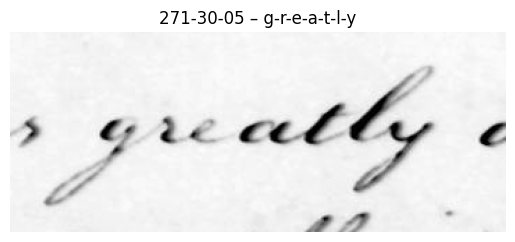

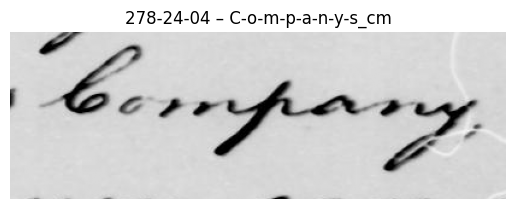

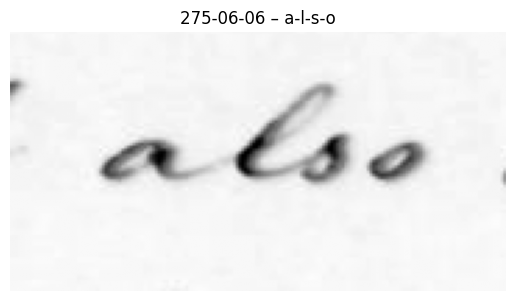

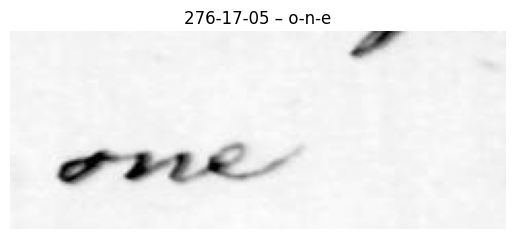

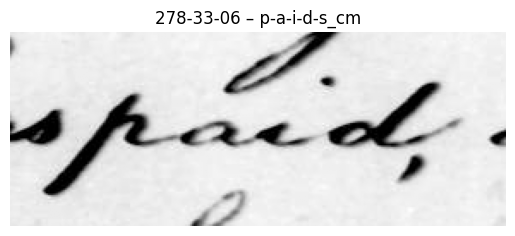

In [71]:

# Pick a few random words from training set
sample_rows = words_df[words_df["split"] == "train"].sample(5, random_state=3)

for _, row in sample_rows.iterrows():
    img = get_word_image(row, padding=3)
    plt.figure()
    plt.title(f"{row['word_id']} – {row['transcription']}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")


# PART 2

### Convert a word image to grayscale, normalize its height, and return a 2D float32 array in [0, 1].

In [72]:
from PIL import Image
import numpy as np

def preprocess_word_image(img, target_height: int = 32) -> np.ndarray:
    """
    img : PIL.Image.Image or np.ndarray --> Raw word image.
    target_height : int --> Desired output height in pixels.
    """
    # Ensure PIL image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)

    # Grayscale
    img = img.convert("L")  # 0–255

    # Resize to fixed height, keep aspect ratio
    w, h = img.size
    if h == 0:
        raise ValueError("Image has zero height")
    new_h = target_height
    new_w = int(round(w * new_h / h))
    img = img.resize((new_w, new_h), Image.BILINEAR)

    # To numpy float32 in [0, 1]
    arr = np.asarray(img, dtype=np.float32) / 255.
    return arr


### Compute a feature vector for a single vertical window of a word image

In [73]:
def extract_window_features(
    window: np.ndarray,
    bin_thresh: float = 0.5
) -> np.ndarray:

    H, W = window.shape

    # Binarize (ink=1, background=0)
    bin_win = (window < bin_thresh).astype(np.float32)

    # Global ink density
    ink_density = bin_win.mean()

    # Split vertically in 3 stripes: top, middle, bottom
    h3 = H // 3 if H >= 3 else 1
    top    = bin_win[:h3, :]
    middle = bin_win[h3:2*h3, :]
    bottom = bin_win[2*h3:, :]

    top_density    = top.mean() if top.size > 0 else 0.0
    middle_density = middle.mean() if middle.size > 0 else 0.0
    bottom_density = bottom.mean() if bottom.size > 0 else 0.0

    # Average number of vertical transitions per column
    if H > 1:
        transitions_per_col = np.abs(np.diff(bin_win, axis=0)).sum(axis=0)
        mean_transitions = transitions_per_col.mean()
    else:
        mean_transitions = 0.0

    feat = np.array(
        [ink_density, top_density, middle_density, bottom_density, mean_transitions],
        dtype=np.float32
    )
    return feat


### Word image → séquence de features (sliding window)

Convert a word image to a sequence of feature vectors using a vertical sliding window.

In [74]:
WINDOW_HEIGHT = 32
WINDOW_WIDTH = 4
WINDOW_STEP = 2

In [75]:
def word_image_to_sequence(
    img,
    target_height: int = WINDOW_HEIGHT,
    window_width: int = WINDOW_WIDTH,
    step: int = WINDOW_STEP,
) -> np.ndarray:

    """
    img : PIL.Image.Image or np.ndarray -->  Raw word image.
    target_height : int --> Desired height after preprocessing.
    window_width : int --> Width of the sliding window (pixels).
    step : int --> Horizontal step between windows (pixels).

    """
    arr = preprocess_word_image(img, target_height=target_height)
    H, W = arr.shape

    feats = []
    x = 0
    while x + window_width <= W:
        window = arr[:, x:x + window_width]
        f = extract_window_features(window)
        feats.append(f)
        x += step

    # If the word is too narrow, we take at least one window
    #Sequence of shape (T, d), where T is the number of windows and d is the feature dimension

    if not feats:
        window = arr
        feats.append(extract_window_features(window))

    seq = np.stack(feats, axis=0)  # (T, d)
    return seq


### Build feature sequences for each word in words_df
then store them in the global dict word_sequences

In [76]:
# Cache global : word_id -> np.ndarray(T, d)
word_sequences: dict[str, np.ndarray] = {}

def build_word_sequences(
    words_df,
    subset: str | None = None,
    target_height: int = WINDOW_HEIGHT,
    window_width: int = WINDOW_WIDTH,
    step: int = WINDOW_STEP,
):

    global word_sequences
    word_sequences = {}

    if subset is not None:
        df = words_df[words_df["split"] == subset]
    else:
        df = words_df

    print(f"Building sequences for {len(df)} words (subset={subset})")

    for _, row in df.iterrows():
        img = get_word_image(row, padding=2)
        seq = word_image_to_sequence(
            img,
            target_height=target_height,
            window_width=window_width,
            step=step
        )
        word_sequences[row["word_id"]] = seq

    print("Done. Stored sequences for", len(word_sequences), "words.")


Global feature normalisation for DTW sequences

In [77]:
FEATURE_MEAN = None
FEATURE_STD = None

def fit_feature_normalization(words_df, split="train"):
    """
    Compute global mean/std of sliding-window features on a subset of words
    (default: training split) and store them in FEATURE_MEAN / FEATURE_STD.
    """
    global FEATURE_MEAN, FEATURE_STD

    seqs = []
    for _, row in words_df[words_df["split"] == split].iterrows():
        wid = row["word_id"]
        seq = word_sequences.get(wid)
        if seq is not None:
            seqs.append(seq)

    if not seqs:
        raise RuntimeError("No sequences found to fit normalisation.")

    all_feats = np.vstack(seqs)  # [total_T, D]
    FEATURE_MEAN = all_feats.mean(axis=0, keepdims=True)
    FEATURE_STD = all_feats.std(axis=0, keepdims=True) + 1e-8  # avoid division by 0


def normalize_sequence(seq):
    """
    Apply z-normalisation using FEATURE_MEAN / FEATURE_STD.
    If stats are not fitted yet, returns seq unchanged.
    """
    if FEATURE_MEAN is None or FEATURE_STD is None:
        return seq
    return (seq - FEATURE_MEAN) / FEATURE_STD


Fit feature normalisation on TRAIN words

### Compute DTW distance between two sequences of feature vectors

In [78]:
def dtw_distance(seq1, seq2, band=None):
    T1, d1 = seq1.shape
    T2, d2 = seq2.shape

    # Initialize cost matrix with +inf
    D = np.full((T1 + 1, T2 + 1), np.inf)
    D[0, 0] = 0.0

    for i in range(1, T1 + 1):
        # Sakoe-Chiba band constraint
        j_start = 1
        j_end = T2 + 1
        if band is not None:
            j_start = max(1, i - band)
            j_end   = min(T2 + 1, i + band)

        for j in range(j_start, j_end):
            dist = np.sum((seq1[i-1] - seq2[j-1])**2)
            D[i, j] = dist + min(D[i-1, j], D[i, j-1], D[i-1, j-1])


    # This prevents short words from always having smaller distances
    return D[T1, T2] / (T1 + T2)

# TEST

In [79]:
train_words = words_df[words_df["split"] == "train"]

# How many times does each transcription appear?
counts = train_words["transcription"].value_counts()
print(counts.head(20))  # just to take a look

# words that appear at least two times
repeated = counts[counts >= 2]
print("\nNumber of words with at least 2 occurrences :", len(repeated))



transcription
t-o              128
t-h-e            124
o-f               64
a-n-d             63
a-r-e             57
y-o-u             43
f-o-r             37
s_mi              34
b-e               29
Y-o-u             27
w-i-t-h           26
a-s               25
a-t               25
t-h-a-t           25
i-s               21
t-h-e-y           19
y-o-u-r           19
i-n               19
w-h-i-c-h         19
C-a-p-t-a-i-n     18
Name: count, dtype: int64

Number of words with at least 2 occurrences : 271


In [80]:
train_words = words_df[words_df["split"] == "train"]

# Transcriptions that appear at least two times
counts = train_words["transcription"].value_counts()
repeated = counts[counts >= 2]

if len(repeated) == 0:
    print("No transaction appear two times in train")
else:
    trans = repeated.index[0]
    same = train_words[train_words["transcription"] == trans]

    row_a = same.iloc[0]
    row_b = same.iloc[1]

    # to ensure you have the sequence
    def get_seq(row):
        wid = row["word_id"]
        if wid in word_sequences:
            return word_sequences[wid]
        else:
            img = get_word_image(row, padding=2)
            seq = word_image_to_sequence(img)
            word_sequences[wid] = seq
            return seq

    seq_a = get_seq(row_a)
    seq_b = get_seq(row_b)

    d_same = dtw_distance(seq_a, seq_b, band=10)
    print(f"Test transcription : {trans}")
    print("DTW distance (same word):", d_same)

    # to compare
    diff = train_words[train_words["transcription"] != trans]
    if len(diff) > 0:
        row_c = diff.iloc[0]
        seq_c = get_seq(row_c)
        d_diff = dtw_distance(seq_a, seq_c, band=10)
        print("DTW distance (different word):", d_diff)
    else:
        print("No word with different transcription to compare.")


Test transcription : t-o
DTW distance (same word): 0.7291744596303417
DTW distance (different word): inf


In [81]:
# Re-build feature sequences for the ENTIRE dataset Train + Validation

print("Building features for ALL data...")
build_word_sequences(words_df)

Building features for ALL data...
Building sequences for 3726 words (subset=None)
Done. Stored sequences for 3726 words.


In [82]:
# Fit feature normalisation on TRAIN words, then normalise all sequences

fit_feature_normalization(words_df, split="train")

for wid, seq in list(word_sequences.items()):
    word_sequences[wid] = normalize_sequence(seq)

print("Normalised sequences with mean shape:", FEATURE_MEAN.shape)


Normalised sequences with mean shape: (1, 5)


PART 3: RETRIEVAL AND EVALUATION


Load Keywords and Define Gallery

In [83]:

# We will search for queries inside the 'train' split
gallery_df = words_df[words_df["split"] == "train"]
gallery_ids = gallery_df["word_id"].values

# 2. Load Keywords
try:
    keywords_df = pd.read_csv(
        DATA_ROOT / "keywords.tsv",
        sep="\t",
        header=None,
        names=["keyword"],
        dtype=str
    )
    print(f"Loaded {len(keywords_df)} keywords to spot.")
except FileNotFoundError:
    print("Warning: keywords.tsv not found. Using a manual list.")
    keywords_df = pd.DataFrame({"keyword": ["Orders", "government", "instructions", "letter"]})

print("First 5 keywords:", keywords_df["keyword"].head().tolist())

Loaded 35 keywords to spot.
First 5 keywords: ['c-a-r-e-f-u-l', 'R-e-g-i-m-e-n-t', 'M-r-s_pt', 'O-f-f-i-c-e-r-s', 'o-p-p-o-r-t-u-n-i-t-y']


The Retrieval Function

In [84]:
DTW_BAND = 20

def retrieve_top_k(query_seq, gallery_ids, k=5, band=DTW_BAND):

    distances = []

    # Iterate over all training words
    for gid in gallery_ids:
        if gid not in word_sequences:
            continue

        gal_seq = word_sequences[gid]

        # Compute DTW distance
        dist = dtw_distance(query_seq, gal_seq, band=band)
        distances.append((gid, dist))

    # Sort by distance
    distances.sort(key=lambda x: x[1])

    return distances[:k]

Some more utils for evaluation

In [85]:
# Return a full ranking of all gallery word_ids by DTW distance
def rank_gallery_dtw(query_seq, gallery_ids, band=10):
    distances = []

    for gid in gallery_ids:
        # re-use the same logic as in retrieve_top_k
        if gid not in word_sequences:
            continue

        gal_seq = word_sequences[gid]
        dist = dtw_distance(query_seq, gal_seq, band=band)
        distances.append((gid, dist))

    # Sort by distance (smaller = more similar)
    distances.sort(key=lambda x: x[1])
    return distances  # full list, not truncated

# Compute Average Precision (AP) for one query.
def average_precision(ranked_ids, relevant_ids):
    if len(relevant_ids) == 0:
        return 0.0

    hits = 0
    sum_prec = 0.0

    for rank, wid in enumerate(ranked_ids, start=1):
        if wid in relevant_ids:
            hits += 1
            sum_prec += hits / rank

    if hits == 0:
        return 0.0

    return sum_prec / len(relevant_ids)

# Compute (recall, precision) points for one query, at each relevant hit.
def pr_curve_from_ranking(ranked_ids, relevant_ids):
    precisions = []
    recalls = []

    hits = 0
    num_relevant = len(relevant_ids)
    if num_relevant == 0:
        return np.array([]), np.array([])

    for rank, wid in enumerate(ranked_ids, start=1):
        if wid in relevant_ids:
            hits += 1
            precisions.append(hits / rank)
            recalls.append(hits / num_relevant)

    return np.array(recalls), np.array(precisions)


Visualization Function

In [86]:
def visualize_retrieval(query_row, top_matches):
    """
    Plot the query image and the top k retrieved images.
    """
    k = len(top_matches)
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 3))

    # 1. Plot Query
    query_img = get_word_image(query_row)
    axes[0].imshow(query_img, cmap="gray")
    axes[0].set_title(f"QUERY:\n{query_row['transcription']}")
    axes[0].axis("off")

    # 2. Plot Matches
    for i, (wid, dist) in enumerate(top_matches):
        match_row = words_df[words_df["word_id"] == wid].iloc[0]
        match_img = get_word_image(match_row)

        # Color title green if correct, red if wrong
        is_correct = (match_row['transcription'] == query_row['transcription'])
        color = "green" if is_correct else "red"

        axes[i+1].imshow(match_img, cmap="gray")
        axes[i+1].set_title(f"#{i+1} (d={dist:.1f})\n{match_row['transcription']}", color=color)
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()

Run the Evaluation Loop

--- Starting Evaluation on 3 random keywords ---

Spotting Keyword: 'g-r-e-a-t-l-y'
Precision@5: 0.00 (0/5 correct)


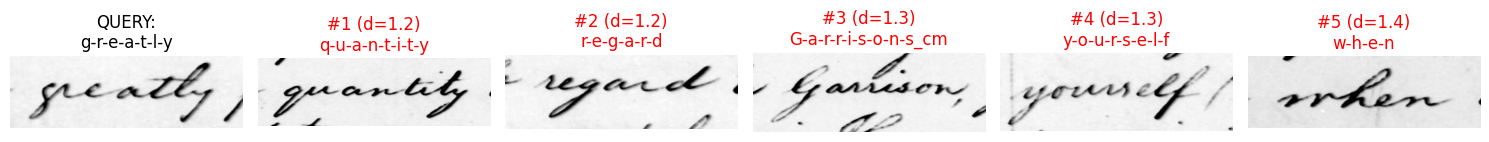


Spotting Keyword: 'C-a-p-t-a-i-n'
Precision@5: 0.40 (2/5 correct)


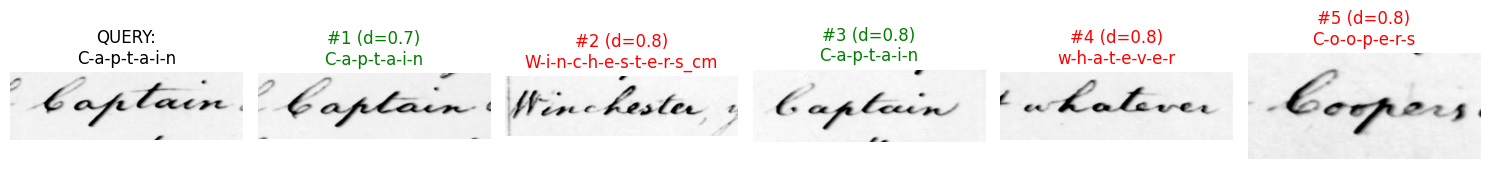


Spotting Keyword: 'w-a-n-t-e-d'
Precision@5: 0.00 (0/5 correct)


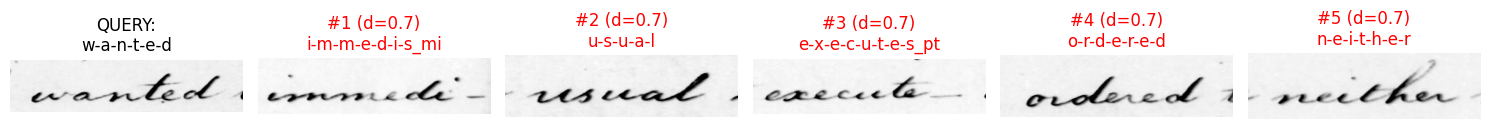

------------------------------
Average Precision@5 over 3 queries: 0.13


In [87]:
import random

# Settings
TOP_K = 5
NUM_KEYWORDS_TO_TEST = 3  # Limit to 3 keywords to save time during testing

print(f"--- Starting Evaluation on {NUM_KEYWORDS_TO_TEST} random keywords ---")

# Filter keywords that actually exist in our validation set
valid_keywords = []
val_df = words_df[words_df["split"] == "val"]

for kw in keywords_df["keyword"]:
    if not val_df[val_df["transcription"] == kw].empty:
        valid_keywords.append(kw)

# Pick random keywords to test
test_keywords = random.sample(valid_keywords, min(len(valid_keywords), NUM_KEYWORDS_TO_TEST))

total_precision = 0

for kw in test_keywords:
    print(f"\nSpotting Keyword: '{kw}'")

    # 1. Get a query image instance from the VALIDATION set
    query_candidates = val_df[val_df["transcription"] == kw]
    query_row = query_candidates.iloc[0] # Pick the first occurrence as our query

    # 2. Get the feature sequence
    if query_row["word_id"] not in word_sequences:
        print("Feature sequence missing, skipping...")
        continue
    query_seq = word_sequences[query_row["word_id"]]

    # 3. Run Retrieval
    top_matches = retrieve_top_k(query_seq, gallery_ids, k=TOP_K, band=DTW_BAND)

    # 4. Calculate Precision
    correct_count = 0
    for wid, dist in top_matches:
        trans = words_df[words_df["word_id"] == wid].iloc[0]["transcription"]
        if trans == kw:
            correct_count += 1

    precision = correct_count / TOP_K
    total_precision += precision
    print(f"Precision@{TOP_K}: {precision:.2f} ({correct_count}/{TOP_K} correct)")

    # 5. Visualize
    visualize_retrieval(query_row, top_matches)

print("-" * 30)
print(f"Average Precision@{TOP_K} over {len(test_keywords)} queries: {total_precision / len(test_keywords):.2f}")

Number of query instances: 69
DTW mAP over 69 queries: 0.126


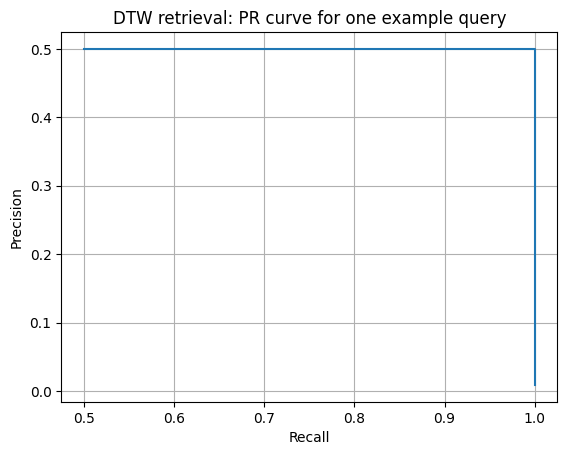

In [88]:
# --- Full DTW retrieval evaluation: + one PR curve example ---

BAND = 10
MAX_QUERIES_PER_KEYWORD = 5  # you can increase this if runtime is OK

train_df = words_df[words_df["split"] == "train"]
val_df   = words_df[words_df["split"] == "val"]

# Build a list of query instances: some occurrences of each keyword in VAL
all_query_rows = []
for kw in keywords_df["keyword"]:
    kw_val_rows = val_df[val_df["transcription"] == kw]
    if kw_val_rows.empty:
        continue

    n = min(MAX_QUERIES_PER_KEYWORD, len(kw_val_rows))
    # fixed random_state for reproducibility
    sampled = kw_val_rows.sample(n=n, random_state=0)
    all_query_rows.extend(sampled.to_dict("records"))

print(f"Number of query instances: {len(all_query_rows)}")

ap_values = []
example_pr = None

for q_idx, q_dict in enumerate(all_query_rows):
    query_row = pd.Series(q_dict)

    # make sure we have a feature sequence
    q_id = query_row["word_id"]
    if q_id not in word_sequences:
        continue

    query_seq = word_sequences[q_id]

    # Full DTW ranking over the training gallery
    full_ranking = rank_gallery_dtw(query_seq, gallery_ids, band=BAND)
    # Convert IDs to strings to be consistent when comparing
    ranked_ids = [str(wid) for wid, dist in full_ranking]

    # Relevant documents: all TRAIN words with the same transcription
    kw = query_row["transcription"]
    rel_ids = set(
        train_df[train_df["transcription"] == kw]["word_id"].astype(str)
    )

    if len(rel_ids) == 0:
        continue

    ap = average_precision(ranked_ids, rel_ids)
    ap_values.append(ap)

    # Keep the first non-empty query as an example for PR curve
    if example_pr is None:
        example_pr = pr_curve_from_ranking(ranked_ids, rel_ids)

# Report mAP
if ap_values:
    mAP = float(np.mean(ap_values))
    print(f"DTW mAP over {len(ap_values)} queries: {mAP:.3f}")
else:
    print("No AP values computed (no valid queries).")

# Plot one recall–precision curve as an example
if example_pr is not None:
    recalls, precisions = example_pr
    plt.figure()
    plt.step(recalls, precisions, where="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("DTW retrieval: PR curve for one example query")
    plt.grid(True)
    plt.show()


In [89]:
def build_pair_dataset(words_df, split, keyword_list=None,
                       max_pos_pairs_per_word=None, random_state=0):
    """
    Construct a dataset of (query_id, candidate_id, same_word) pairs
    for a given split ('train' or 'val').

    - Positives: two word_id with the same transcription
                 (optionally restricted to keywords).
    - Negatives: two word_id with different transcriptions.
    """

    rng = np.random.default_rng(random_state)

    # Keep only words from the requested split
    subset = words_df[words_df["split"] == split].copy()

    # Optionally restrict to keywords (based on transcription)
    if keyword_list is not None and "transcription" in subset.columns:
        subset = subset[subset["transcription"].isin(keyword_list)]

    if "transcription" not in subset.columns:
        raise ValueError("words_df must contain a 'transcription' column")

    # transcription -> list of word_ids
    by_trans = {}
    for _, row in subset.iterrows():
        by_trans.setdefault(row["transcription"], []).append(row["word_id"])

    all_ids = subset["word_id"].tolist()
    trans_by_id = dict(zip(subset["word_id"], subset["transcription"]))

    pairs = []

    for trans, ids in by_trans.items():
        # need at least two occurrences for a positive pair
        if len(ids) < 2:
            continue

        # all unordered positive pairs for this transcription
        pos_pairs = [(ids[i], ids[j])
                     for i in range(len(ids))
                     for j in range(i + 1, len(ids))]

        rng.shuffle(pos_pairs)

        # optionally limit the number of positive pairs per transcription
        if max_pos_pairs_per_word is not None:
            pos_pairs = pos_pairs[:max_pos_pairs_per_word]

        for q_id, c_id in pos_pairs:
            # positive example
            pairs.append((q_id, c_id, 1))

            # corresponding negative example for the same query
            while True:
                neg_c_id = rng.choice(all_ids)
                if trans_by_id[neg_c_id] != trans:
                    break
            pairs.append((q_id, neg_c_id, 0))

    pairs_df = pd.DataFrame(pairs,
                            columns=["query_id", "candidate_id", "same_word"])
    return pairs_df

In [90]:
# Optional: restrict positives to true keyword transcriptions
# (if keywords_df is available)
keyword_list = None
if "keywords_df" in globals():
    keyword_list = set(keywords_df["keyword"])

# Limit the number of positive pairs per transcription to keep the
# training set balanced and avoid over-representing very frequent words.
MAX_POS_PAIRS_PER_WORD = 80  # you can tweak this

train_pairs_df = build_pair_dataset(
    words_df,
    split="train",
    keyword_list=keyword_list,
    max_pos_pairs_per_word=MAX_POS_PAIRS_PER_WORD,
    random_state=42,
)

val_pairs_df = build_pair_dataset(
    words_df,
    split="val",
    keyword_list=keyword_list,
    max_pos_pairs_per_word=MAX_POS_PAIRS_PER_WORD,
    random_state=43,
)

print("Train pairs:", train_pairs_df.shape)
print("Val pairs:", val_pairs_df.shape)
train_pairs_df.head()


Train pairs: (1188, 3)
Val pairs: (132, 3)


,query_id,candidate_id,same_word
0,273-01-02,275-01-02,1
1,273-01-02,276-21-03,0
2,273-01-02,279-01-02,1
3,273-01-02,275-32-06,0
4,270-01-03,271-30-03,1


In [91]:
def compute_pair_features(pairs_df, band=20):
    """Compute pairwise features for each (query_id, candidate_id) pair.

    Features:
        - dtw_raw   : un-normalized DTW cost
        - dtw_norm  : DTW cost normalized by (len_query + len_cand)
        - len_query : sequence length of the query word
        - len_cand  : sequence length of the candidate word
        - avg_len   : average sequence length
        - len_diff  : absolute difference of lengths
        - len_ratio : min(len_q, len_c) / max(len_q, len_c)
    """

    feature_rows = []

    n = len(pairs_df)
    print(f"Computing pair features for {n} pairs...")

    for idx, row in pairs_df.iterrows():
        q_id = str(row["query_id"])
        c_id = str(row["candidate_id"])

        # Skip if we don't have sequences for one of the words
        if q_id not in word_sequences or c_id not in word_sequences:
            continue

        seq_q = word_sequences[q_id]
        seq_c = word_sequences[c_id]

        Tq = seq_q.shape[0]
        Tc = seq_c.shape[0]

        # Skip zero-length sequences (would give inf / NaN)
        if Tq == 0 or Tc == 0:
            continue

        # Normalized DTW distance
        dtw_norm = dtw_distance(seq_q, seq_c, band=band)

        # If DTW failed (no valid path with the band), skip this pair
        if not np.isfinite(dtw_norm):
            continue

        # Recover "raw" DTW cost
        dtw_raw = dtw_norm * (Tq + Tc)

        avg_len  = 0.5 * (Tq + Tc)
        len_diff = abs(Tq - Tc)
        len_ratio = min(Tq, Tc) / max(Tq, Tc)  # safe because both > 0

        feature_rows.append({
            "query_id": q_id,
            "candidate_id": c_id,
            "same_word": int(row["same_word"]),   # label 0/1

            "dtw_raw": float(dtw_raw),
            "dtw_norm": float(dtw_norm),

            "len_query": int(Tq),
            "len_cand": int(Tc),
            "avg_len": float(avg_len),
            "len_diff": int(len_diff),
            "len_ratio": float(len_ratio),
        })

    feat_df = pd.DataFrame(feature_rows)
    print("Done. Final feature dataset shape:", feat_df.shape)
    return feat_df


# Make sure word_sequences is available for *all* words used in pairs
print("Rebuilding word sequences for ALL data (train + val) before pair feature extraction...")
build_word_sequences(words_df)
print("Total sequences:", len(word_sequences))

PAIR_FEATURE_BAND = DTW_BAND

train_feat_df = compute_pair_features(train_pairs_df, band=PAIR_FEATURE_BAND)
val_feat_df   = compute_pair_features(val_pairs_df,   band=PAIR_FEATURE_BAND)

train_feat_df.head()


Rebuilding word sequences for ALL data (train + val) before pair feature extraction...
Building sequences for 3726 words (subset=None)
Done. Stored sequences for 3726 words.
Total sequences: 3726
Computing pair features for 1188 pairs...
Done. Final feature dataset shape: (916, 10)
Computing pair features for 132 pairs...
Done. Final feature dataset shape: (106, 10)


,query_id,candidate_id,same_word,dtw_raw,dtw_norm,len_query,len_cand,avg_len,len_diff,len_ratio
0,273-01-02,275-01-02,1,29.612084,0.305279,44,53,48.5,9,0.830189
1,273-01-02,276-21-03,0,37.416748,0.356350,44,61,52.5,17,0.721311
2,273-01-02,279-01-02,1,26.951951,0.309793,44,43,43.5,1,0.977273
3,273-01-02,275-32-06,0,19.674099,0.231460,44,41,42.5,3,0.931818
4,270-01-03,271-30-03,1,43.961697,0.457934,44,52,48.0,8,0.846154


In [92]:
# Just to be extra safe: remove any remaining inf / NaN
for df in (train_feat_df, val_feat_df):
    for col in ["dtw_norm", "dtw_raw", "len_query", "len_cand",
                "avg_len", "len_diff", "len_ratio"]:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)

train_feat_df = train_feat_df.dropna()
val_feat_df   = val_feat_df.dropna()


C:\Users\aqual\AppData\Local\Temp\ipykernel_38260\116858102.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace([np.inf, -np.inf], np.nan, inplace=True)


In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# We keep only the most informative and well-behaved features.
feature_cols = [
    "dtw_norm",
    "len_diff",
    "len_ratio",
]

X_train = train_feat_df[feature_cols].values
y_train = train_feat_df["same_word"].values.astype(int)

X_val = val_feat_df[feature_cols].values
y_val = val_feat_df["same_word"].values.astype(int)

print("X_train shape:", X_train.shape)
print("X_val   shape:", X_val.shape)

# Standardize features then fit logistic regression
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs"),
)

log_reg.fit(X_train, y_train)

train_proba = log_reg.predict_proba(X_train)[:, 1]
val_proba   = log_reg.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val   ROC-AUC:", roc_auc_score(y_val,   val_proba))

val_pred = (val_proba >= 0.5).astype(int)
print("Val accuracy @ 0.5:", accuracy_score(y_val, val_pred))


X_train shape: (916, 3)
X_val   shape: (106, 3)
Train ROC-AUC: 0.7025245183350054
Val   ROC-AUC: 0.7951219512195122
Val accuracy @ 0.5: 0.7735849056603774


In [94]:
def rank_gallery_model(query_row, gallery_ids, band=20):
    """
    Rank all gallery words for a given query using the learned model.

    Returns
    -------
    ranked_ids : list of str
        Candidate word_ids sorted by decreasing similarity score.
    feat_df : pandas.DataFrame
        DataFrame with features and 'score' column for inspection.
    """
    q_id = query_row["word_id"]

    # Build (query, candidate) pairs with dummy labels (same_word not used here)
    pairs_df = pd.DataFrame({
        "query_id":    [q_id] * len(gallery_ids),
        "candidate_id": gallery_ids,
        "same_word":   [0] * len(gallery_ids),  # dummy label just to satisfy compute_pair_features
    })

    # Compute DTW-based features for all pairs
    feat_df = compute_pair_features(pairs_df, band=band)

    # Predict probabilities with the trained logistic regression
    X = feat_df[feature_cols].values
    scores = log_reg.predict_proba(X)[:, 1]  # P(same_word=1)

    feat_df["score"] = scores

    # Sort by score (highest probability first)
    feat_df = feat_df.sort_values("score", ascending=False)

    ranked_ids = feat_df["candidate_id"].astype(str).tolist()
    return ranked_ids, feat_df


## Retrieval using the learned similarity model

In this section, we replace raw DTW distance with the probability given by
the logistic regression model trained on pairwise features.

--- Starting Evaluation with learned model on 10 random keywords ---
35 keywords have at least one validation occurrence.

Keyword: M-a-j-o-r
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (2043, 10)
Precision@5: 0.00 (0/5 correct)


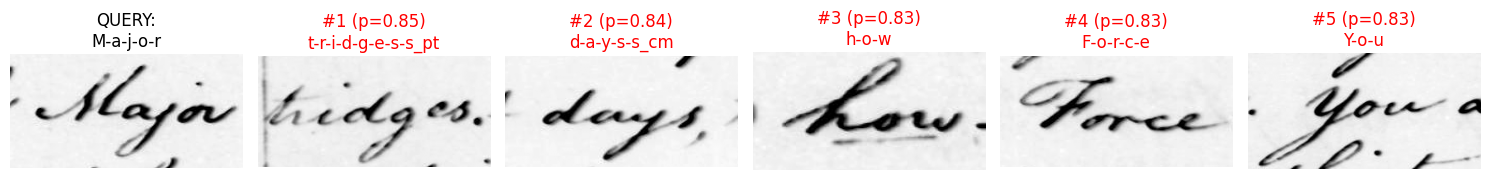


Keyword: s_GW
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1898, 10)
Precision@5: 0.00 (0/5 correct)


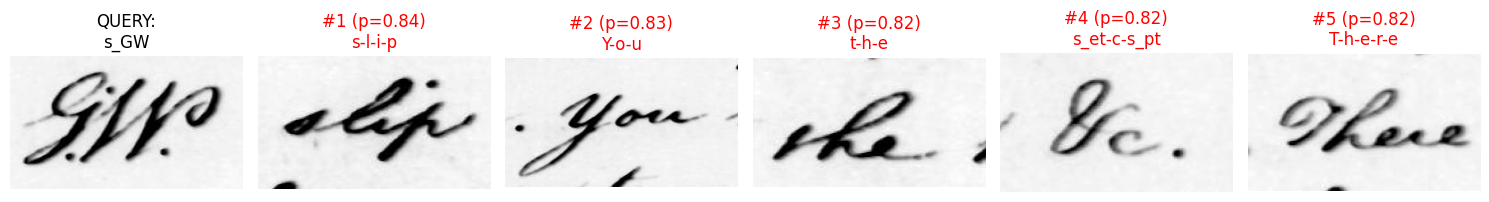


Keyword: g-r-e-a-t-l-y
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1350, 10)
Precision@5: 0.00 (0/5 correct)


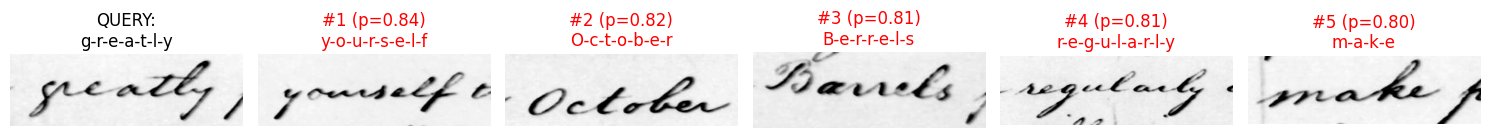


Keyword: l-e-f-t
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1898, 10)
Precision@5: 0.00 (0/5 correct)


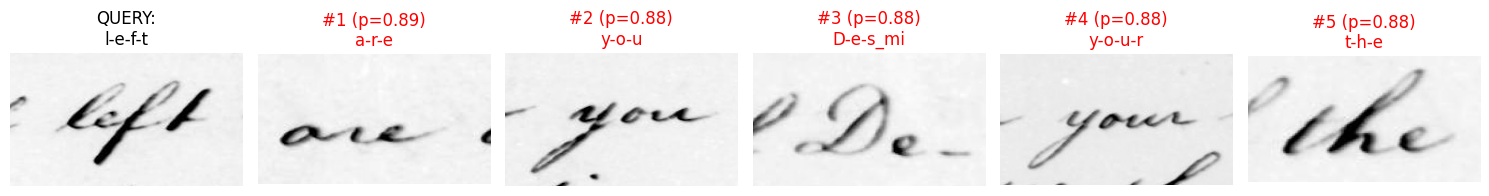


Keyword: w-a-n-t-e-d
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (446, 10)
Precision@5: 0.00 (0/5 correct)


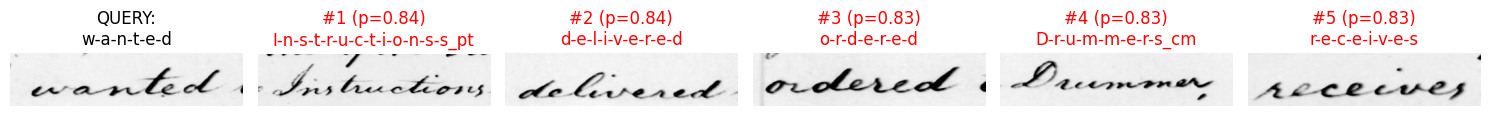


Keyword: t-h-i-n-g-s
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (2052, 10)
Precision@5: 0.00 (0/5 correct)


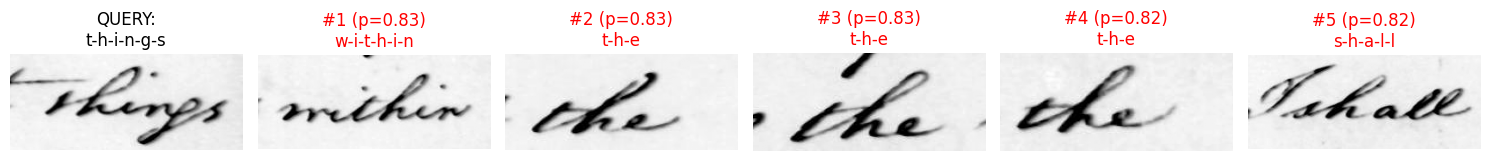


Keyword: V-i-r-g-i-n-i-a
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1548, 10)
Precision@5: 0.20 (1/5 correct)


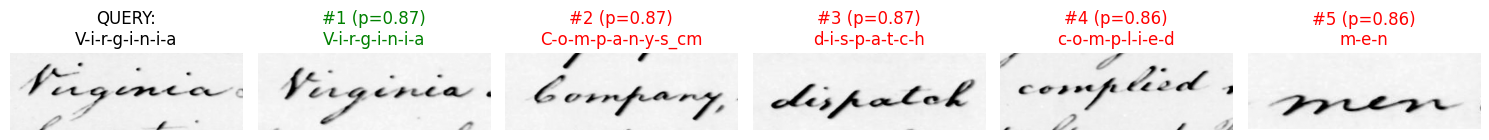


Keyword: t-w-e-l-v-e
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1732, 10)
Precision@5: 0.00 (0/5 correct)


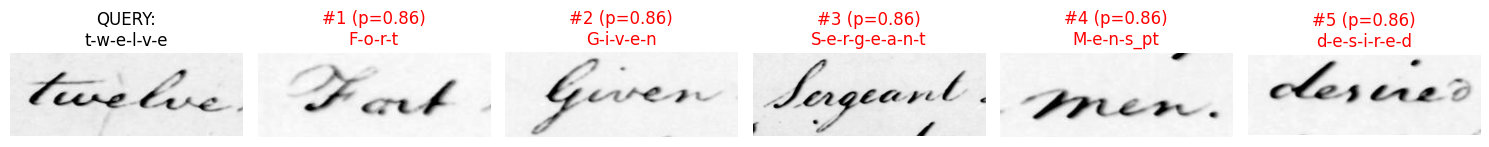


Keyword: s_et-c-s_pt
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1944, 10)
Precision@5: 0.00 (0/5 correct)


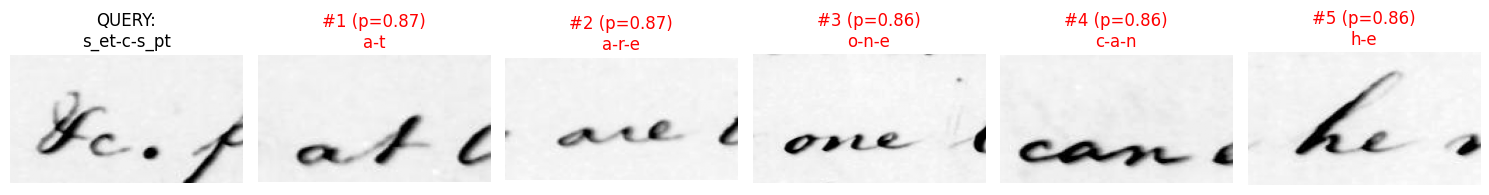


Keyword: O-r-d-e-r-s
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1350, 10)
Precision@5: 0.20 (1/5 correct)


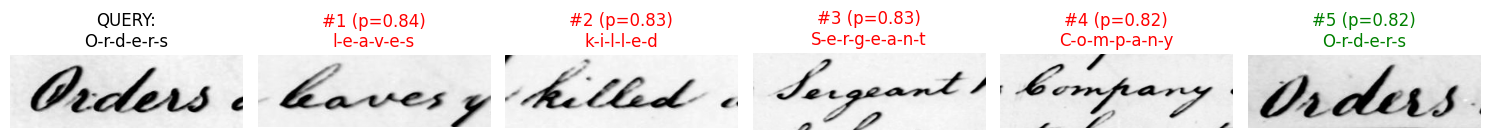

------------------------------
Average Precision@5 over 10 queries: 0.04


In [95]:

# --- Retrieval with learned model (LogisticRegression on pairwise features) ---

def retrieve_top_k_model(query_row, gallery_ids, k=5, band=DTW_BAND):
    """
    Retrieve top-k candidates for a given query occurrence using the
    learned logistic regression model on pairwise features.

    Parameters
    ----------
    query_row : pandas.Series
        Row from words_df corresponding to the query occurrence.
    gallery_ids : list-like
        List of word_id in the gallery (typically all 'train' words).
    k : int
        Number of retrieved candidates.
    band : int
        Sakoe–Chiba band for DTW when computing features.

    Returns
    -------
    list of (candidate_id, score)
        candidate_id is a word_id, score is P(same_word=1).
    """
    query_id = str(query_row["word_id"])

    # Build a DataFrame of all (query, candidate) pairs for this query
    pairs = [
        {"query_id": query_id, "candidate_id": str(cid), "same_word": 0}
        for cid in gallery_ids
    ]
    pairs_df = pd.DataFrame(pairs)

    # Compute pairwise features
    feat_df = compute_pair_features(pairs_df, band=band)

    if feat_df.empty:
        return []

    # Predict probabilities with the trained logistic regression
    X = feat_df[feature_cols].values
    scores = log_reg.predict_proba(X)[:, 1]  # P(same_word=1)

    feat_df["score"] = scores

    # Sort by score (highest probability first)
    feat_df = feat_df.sort_values("score", ascending=False)

    top = feat_df.head(k)
    results = list(zip(top["candidate_id"].tolist(), top["score"].tolist()))
    return results


def visualize_retrieval_model(query_row, top_matches):
    """
    Visualization for retrieval results using model scores (probabilities).

    top_matches is a list of (word_id, score).
    """
    k = len(top_matches)
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 3))

    # 1. Plot Query
    query_img = get_word_image(query_row)
    axes[0].imshow(query_img, cmap="gray")
    axes[0].set_title(f"QUERY:\n{query_row['transcription']}")
    axes[0].axis("off")

    # 2. Plot Matches
    for i, (wid, score) in enumerate(top_matches):
        match_row = words_df[words_df["word_id"] == wid].iloc[0]
        match_img = get_word_image(match_row)

        # Color title green if correct, red if wrong
        is_correct = (match_row['transcription'] == query_row['transcription'])
        color = "green" if is_correct else "red"

        axes[i+1].imshow(match_img, cmap="gray")
        axes[i+1].set_title(f"#{i+1} (p={score:.2f})\n{match_row['transcription']}", color=color)
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()


# --- Evaluation loop using the learned model instead of raw DTW ---

import random

TOP_K = 5
NUM_KEYWORDS_TO_TEST = 10  # you can increase this for a more stable estimate
BAND = 20

print(f"--- Starting Evaluation with learned model on {NUM_KEYWORDS_TO_TEST} random keywords ---")

# Validation words
val_df = words_df[words_df["split"] == "val"]

# Keep only keywords that actually appear in validation set
valid_keywords = []
for kw in keywords_df["keyword"]:
    if not val_df[val_df["transcription"] == kw].empty:
        valid_keywords.append(kw)

print(f"{len(valid_keywords)} keywords have at least one validation occurrence.")

if len(valid_keywords) == 0:
    print("No valid keywords found in validation set.")
else:
    # Randomly choose some keywords to test
    test_keywords = random.sample(valid_keywords, min(NUM_KEYWORDS_TO_TEST, len(valid_keywords)))

    total_precision = 0.0

    for kw in test_keywords:
        print("\nKeyword:", kw)

        # All occurrences of this keyword in validation set
        kw_val_rows = val_df[val_df["transcription"] == kw]

        # Pick a random occurrence as query
        query_row = kw_val_rows.sample(n=1).iloc[0]

        # Retrieve from the *train* gallery using the learned model
        top_matches = retrieve_top_k_model(query_row, gallery_ids, k=TOP_K, band=BAND)

        if not top_matches:
            print("No matches returned for this query.")
            continue

        # Compute Precision@K
        correct_count = 0
        for wid, score in top_matches:
            trans = words_df[words_df["word_id"] == wid].iloc[0]["transcription"]
            if trans == kw:
                correct_count += 1

        precision = correct_count / TOP_K
        total_precision += precision
        print(f"Precision@{TOP_K}: {precision:.2f} ({correct_count}/{TOP_K} correct)")

        # Visualize retrieval with model scores
        visualize_retrieval_model(query_row, top_matches)

    print("-" * 30)
    if len(test_keywords) > 0:
        print(f"Average Precision@{TOP_K} over {len(test_keywords)} queries: {total_precision / len(test_keywords):.2f}")


Number of query instances (model eval): 69
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1053, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (839, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1858, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1602, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1414, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1900, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (133, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (884, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (1548, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (359, 10)
Computing pair features for 2433 pairs...
Done. Final feature dataset shape: (204

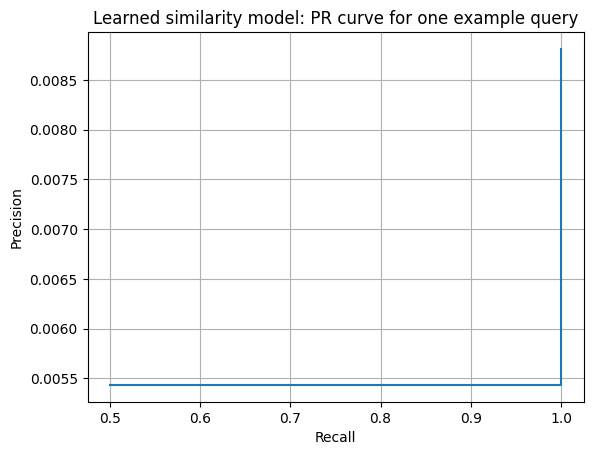

In [96]:
# --- Full retrieval evaluation for the learned similarity model ---

BAND_MODEL = DTW_BAND            # should match PAIR_FEATURE_BAND used for features
MAX_QUERIES_PER_KEYWORD = 5  # increase if runtime is OK

train_df = words_df[words_df["split"] == "train"]
val_df   = words_df[words_df["split"] == "val"]

# Build list of query instances (VAL words) for which we do retrieval
all_query_rows = []
for kw in keywords_df["keyword"]:
    kw_val_rows = val_df[val_df["transcription"] == kw]
    if kw_val_rows.empty:
        continue

    n = min(MAX_QUERIES_PER_KEYWORD, len(kw_val_rows))
    sampled = kw_val_rows.sample(n=n, random_state=0)
    all_query_rows.extend(sampled.to_dict("records"))

print(f"Number of query instances (model eval): {len(all_query_rows)}")

ap_values_model = []
example_pr_model = None

for q_dict in all_query_rows:
    query_row = pd.Series(q_dict)

    # Full ranking with the learned model
    ranked_ids, feat_df = rank_gallery_model(query_row, gallery_ids, band=BAND_MODEL)

    # Relevant documents: all TRAIN words with the same transcription
    kw = query_row["transcription"]
    rel_ids = set(
        train_df[train_df["transcription"] == kw]["word_id"].astype(str)
    )
    if not rel_ids:
        continue

    ap = average_precision(ranked_ids, rel_ids)
    ap_values_model.append(ap)

    # Save first non-empty query for a PR curve example
    if example_pr_model is None:
        example_pr_model = pr_curve_from_ranking(ranked_ids, rel_ids)

# Report mAP
if ap_values_model:
    mAP_model = float(np.mean(ap_values_model))
    print(f"Learned model mAP over {len(ap_values_model)} queries: {mAP_model:.3f}")
else:
    print("No AP values computed for the learned model (no valid queries).")

# Plot one recall–precision curve as an example
if example_pr_model is not None:
    recalls, precisions = example_pr_model
    plt.figure()
    plt.step(recalls, precisions, where="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Learned similarity model: PR curve for one example query")
    plt.grid(True)
    plt.show()


In [97]:
# After the loop, just before plotting:
print("Example query keyword:", query_row["transcription"])
print("Number of relevant gallery words:", len(rel_ids))
print("Total gallery size:", len(gallery_ids))


Example query keyword: p-l-a-c-e
Number of relevant gallery words: 4
Total gallery size: 2433


In [98]:
# After feat_df is sorted in rank_gallery_model:
rel_mask = feat_df["candidate_id"].astype(str).isin(rel_ids)
rel_ranks = np.where(rel_mask.values)[0]  # 0-based indices
print("Ranks of relevant docs (0-based):", rel_ranks[:10])


Ranks of relevant docs (0-based): [  97  305  338 1466]


In [99]:
# Same query_row, rel_ids, gallery_ids as before, but using pure DTW
query_seq = word_sequences[query_row["word_id"]]
full_ranking_dtw = rank_gallery_dtw(query_seq, gallery_ids, band=BAND_MODEL)
ranked_ids_dtw = [str(wid) for wid, dist in full_ranking_dtw]

# Ranks of relevant docs under DTW
rel_ranks_dtw = [
    idx for idx, wid in enumerate(ranked_ids_dtw)
    if wid in rel_ids
]
print("DTW ranks of relevant docs (0-based):", rel_ranks_dtw)
print("AP (DTW) for this query:",
      average_precision(ranked_ids_dtw, rel_ids))
print("AP (model) for this query:",
      average_precision(ranked_ids, rel_ids))


DTW ranks of relevant docs (0-based): [280, 335, 861, 1403]
AP (DTW) for this query: 0.003960095271216887
AP (model) for this query: 0.007079059975149188
